In [ ]:
# default_exp core

# elec_consumption

Cluster analysis and statistical learning for electricity consumption profiles.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%matplotlib inline
from elec_consumption.core import *
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
#hide
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [4 * 1.61803398875, 4]

In [ ]:
#hide
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

## 1. Introduction

There are 500 time series spanning 122 days (Aug 1, 2017 to Nov 30, 2017).

Preview first five rows for first five households. Unit is presumed to be kV.

In [ ]:
#hide_input
df.iloc[:5, :5]

household,0,1,2,3,4
datetime,,,,,
2017-08-01 00:00:00,0.094,0.028,0.116,0.096,0.189
2017-08-01 00:30:00,0.039,0.050,0.068,0.077,0.156
2017-08-01 01:00:00,0.088,0.060,0.044,0.095,0.118
2017-08-01 01:30:00,0.046,0.023,0.067,0.092,0.145
2017-08-01 02:00:00,0.082,0.020,0.068,0.085,0.153


Power consumption profiles of household 0, 1, 2 on Aug 1, 2017 are plotted:

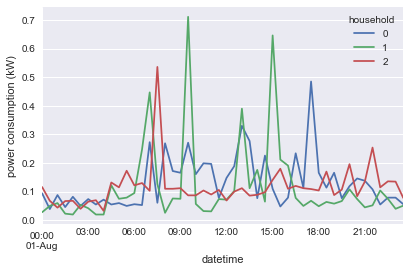

In [ ]:
#hide_input
df[df.index.date == datetime.date(2017, 8, 1)].iloc[:, :3].plot(
    ylabel='power consumption (kW)'
);

Aggregate profile of 0 hourly and compare two series:

In [ ]:
#hide
df_hour_0 = (
    df[df.index.date == datetime.date(2017, 8, 1)].loc[:, 0]
    .resample('1H', closed='left').mean().to_frame()
)
df_hour_0.columns = ['power']
df_hour_0['freq'] = 'hour'
df_hour_0.reset_index(inplace=True)
df_hour_0.set_index(['datetime', 'freq'], inplace=True)

In [ ]:
#hide
df_halfhour_0 = df[df.index.date == datetime.date(2017, 8, 1)].loc[:, 0].to_frame()
df_halfhour_0.columns = ['power']
df_halfhour_0['freq'] = 'half-hour'
df_halfhour_0.reset_index(inplace=True)
df_halfhour_0.set_index(['datetime', 'freq'], inplace=True)

In [ ]:
#hide
df_0 = pd.concat([df_hour_0, df_halfhour_0])

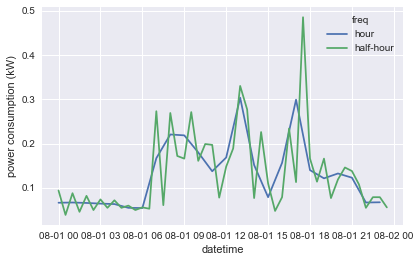

In [ ]:
#hide_input
ax = sns.lineplot(data=df_0, y='power', x='datetime', hue='freq')
ax.set(ylabel='power consumption (kW)');

Daily downsampled mean values of household 0 for the whole period:

All the 48 entries for some dates are missing.

Dates with missing entries are the same for household 0 and 1.

In [ ]:
#hide_input
def get_list_dates_missing(household: int):
    """Find num of missing entries for every day.

    Args:
        household: integer index of given household.
    """
    num_nan_daily = (
        df.iloc[:, household].groupby(df.index.date)
        .apply(lambda x: x.isna().values.sum()).to_frame()
    )
    num_nan_daily.columns = ['num_nan_daily']
    return num_nan_daily[num_nan_daily['num_nan_daily'] > 0]


get_list_dates_missing(0)

,num_nan_daily
2017-08-16,48
2017-09-20,48
2017-09-28,48
2017-09-29,48
2017-10-04,48
2017-10-06,48
2017-10-10,48
2017-10-20,48
2017-10-21,48
2017-10-31,48


In [ ]:
#hide_input
get_list_dates_missing(1)

,num_nan_daily
2017-08-16,48
2017-09-18,48
2017-09-20,48
2017-09-28,48
2017-09-29,48
2017-10-04,48
2017-10-06,48
2017-10-10,48
2017-10-20,48
2017-10-21,48


Hoever, there is household having different set of dates with missing entries.

In [ ]:
#hide_input
get_list_dates_missing(496)

,num_nan_daily
2017-08-16,48
2017-09-18,48
2017-09-20,48
2017-09-28,48
2017-09-29,48
2017-10-04,48
2017-10-06,48
2017-10-10,48
2017-10-20,48
2017-10-21,48


## 2. Cluster Analysis of Households

Households are to be clustered based on either hourly or daily consumption profiles.

## 3. Time Series Analysis

Different statistical model can be built for different clusters of households. Forecasts with two different resolutions, hourly and daily, are expected.